In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

## Read df_merged

In [2]:
#df_merged = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/df_merged.csv')
df_merged = pd.read_pickle('df_merged.pkl')
# Replace infinite values with NaN
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill NaN with a suitable value (e.g., the mean or median)
df_merged.fillna(0, inplace=True)
df_merged

,mean_bpm,std_bpm,median_bpm,mean_ecg_plf,std_ecg_plf,mean_ecg_phf,std_ecg_phf,mean_ecg_plf_phf,std_ecg_plf_phf,mean_eda_scl,...,eye_plf_x,eye_plf_phf_ratio_x,eye_phf_y,eye_plf_y,eye_plf_phf_ratio_y,test_phase,subject,sex,age,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,baseline,100,Femmina,33,0
1,-0.015228,-0.401453,-0.027078,-0.144974,4.000261,0.327108,-0.843138,-0.357578,0.173004,0.187553,...,0.613050,-0.191236,0.610755,0.342245,-0.166698,visual_nback_1,100,Femmina,33,1
2,-0.044564,-0.408063,-0.050983,-0.138752,3.452548,0.309001,-0.753055,-0.344157,0.020611,0.123678,...,0.491899,-0.108778,0.406846,0.147029,-0.184680,visual_nback_2,100,Femmina,33,2
3,-0.046836,-0.384202,-0.068716,-0.028992,1.047923,0.252391,-0.500148,-0.227175,-0.725094,0.062608,...,-0.267206,-0.074606,0.579562,0.340939,-0.151069,visual_nback_3,100,Femmina,33,3
4,-0.055602,-0.228174,-0.077604,-0.055550,0.644565,0.137138,-0.437481,-0.170670,-0.198118,0.089417,...,0.129770,-0.233186,0.397127,0.216030,-0.129621,auditory_nback_1,100,Femmina,33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,0.011271,0.115052,-0.003129,0.212748,-0.357066,-0.219966,-0.570585,0.551249,-0.804783,0.042942,...,-0.072847,-0.136193,0.497027,0.358029,-0.092849,auditory_nback_2,9,Femmina,27,2
986,0.112283,0.080851,0.114218,0.226040,-0.342855,-0.164229,-0.292654,0.464180,-0.654211,0.063492,...,0.805609,-0.225253,0.756656,0.374185,-0.217727,auditory_nback_3,9,Femmina,27,3
987,0.042826,-0.102837,0.046524,0.326800,0.384185,-0.130152,-0.579993,0.521668,-0.363971,0.020210,...,-0.080445,-0.076788,0.021124,-0.042834,-0.062635,dual_nback_1,9,Femmina,27,2
988,0.038935,-0.107785,0.032957,0.435844,-0.293817,-0.098505,-0.871897,0.589039,-0.642485,-0.010505,...,0.431675,-0.186458,0.686287,0.432036,-0.150776,dual_nback_2,9,Femmina,27,3


## Data Exploration and Visualization

In [ ]:
# Basic info
print(df_merged.info())
print(df_merged.describe())

# Check distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df_merged)
plt.title('Distribution of Ratings')
plt.show()

# Check distribution by test phase
plt.figure(figsize=(12, 6))
sns.countplot(x='test_phase', hue='label', data=df_merged[df_merged['test_phase'] != 'baseline'])
plt.title('Rating Distribution by Test Phase')
plt.xticks(rotation=45)
plt.show()

# Check distribution by gender
plt.figure(figsize=(8, 5))
sns.countplot(x='sex', hue='label', data=df_merged[df_merged['test_phase'] != 'baseline'])
plt.title('Rating Distribution by Gender')
plt.show()

# Physiological signals distribution (sample a few)
signal_cols = [col for col in df_merged.columns if col not in ['test_phase', 'subject', 'sex', 'age', 'label']]
for signal in np.random.choice(signal_cols, 5):
    plt.figure(figsize=(8, 5))
    sns.histplot(df_merged[signal], bins=50)
    plt.title(f'Distribution of {signal}')
    plt.show()

# Data Preprocessing and Scaling

## Relabeling by 1-2 bundling in 1 and 3 to 2

In [4]:
# Separate features and target

# Map original labels to grouped labels
label_map = {
    0: 0,
    1: 1,
    2: 1,
    3: 2
}

df_merged3 = df_merged.copy()

df_merged3['label_grouped'] = df_merged3['label'].map(label_map)
y = df_merged3['label_grouped'].values.astype(int)

df_merged3['label'] = y

## Data Definition and Visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 112 entries, mean_bpm to label_grouped
dtypes: float64(106), int64(4), object(2)
memory usage: 866.4+ KB
None
         mean_bpm     std_bpm  median_bpm  mean_ecg_plf  std_ecg_plf  \
count  990.000000  990.000000  990.000000    990.000000   990.000000   
mean     0.038864   -0.125761    0.040567      0.013035    -0.296651   
std      0.086822    0.337523    0.089099      0.208719     0.705896   
min     -0.194794   -0.764473   -0.185492     -0.561501    -0.970029   
25%     -0.012430   -0.351200   -0.011701     -0.137939    -0.732162   
50%      0.020898   -0.162448    0.024120      0.000000    -0.482354   
75%      0.081868    0.000000    0.084738      0.139297     0.000000   
max      0.441747    2.542450    0.459963      0.813189     8.585952   

       mean_ecg_phf  std_ecg_phf  mean_ecg_plf_phf  std_ecg_plf_phf  \
count    990.000000   990.000000        990.000000       990.000000   
mean       0.01864

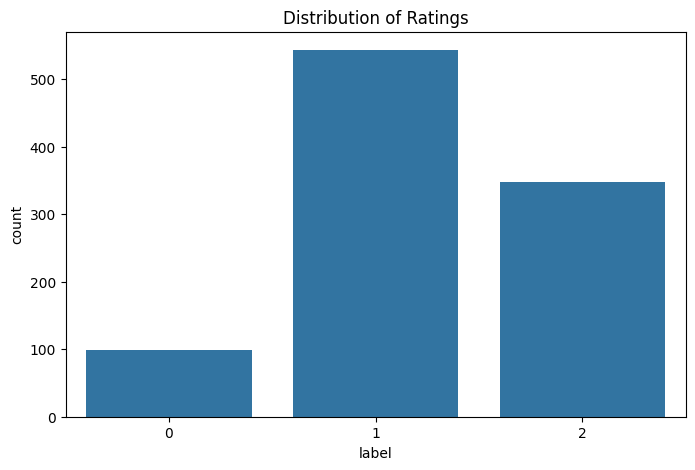

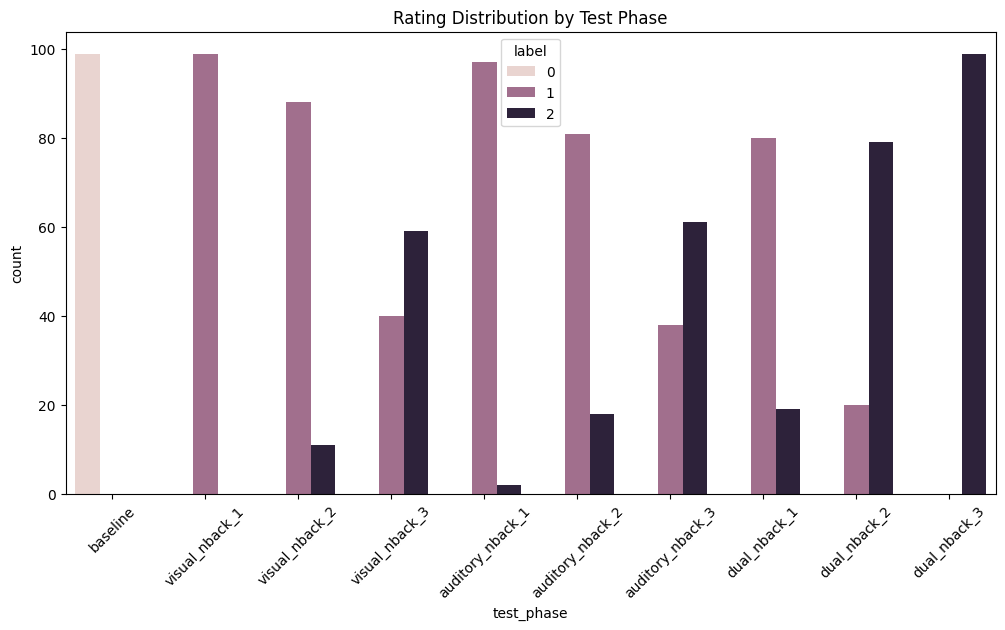

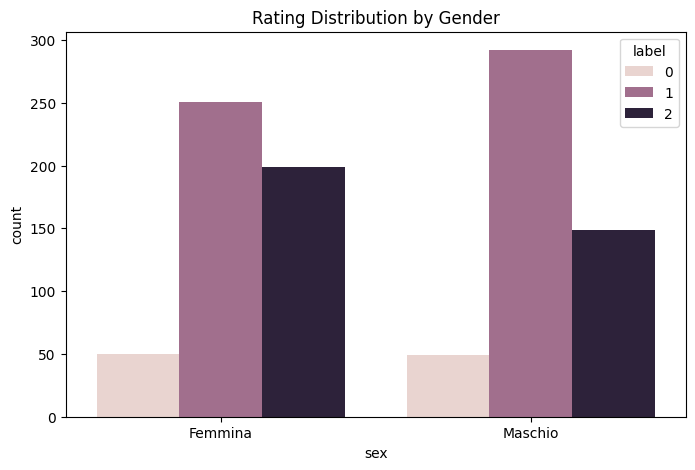

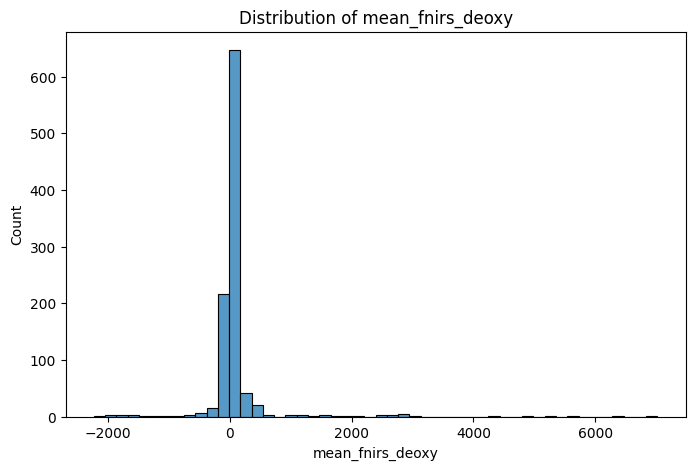

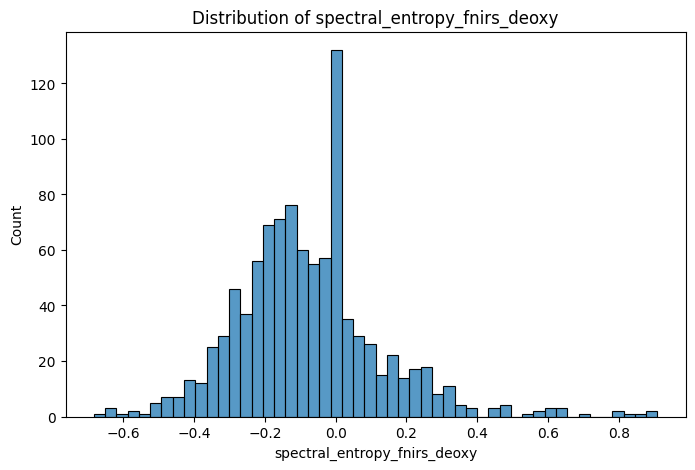

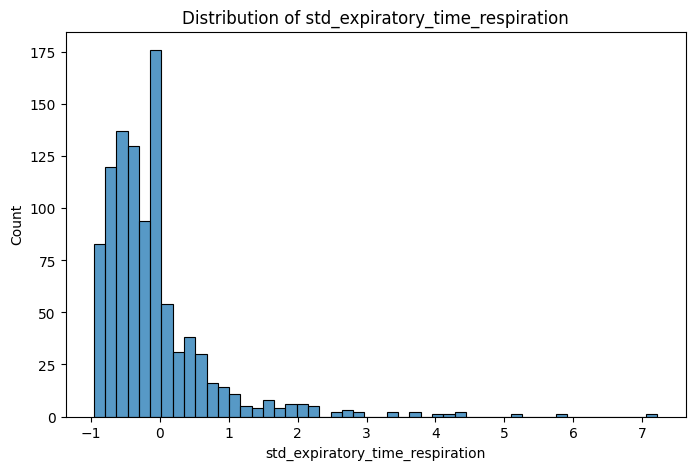

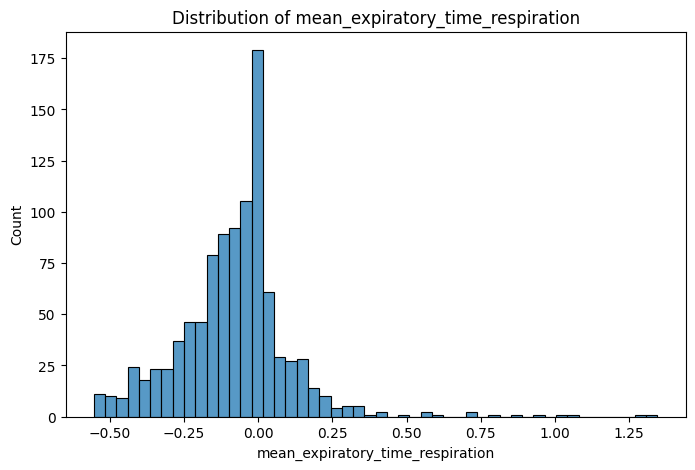

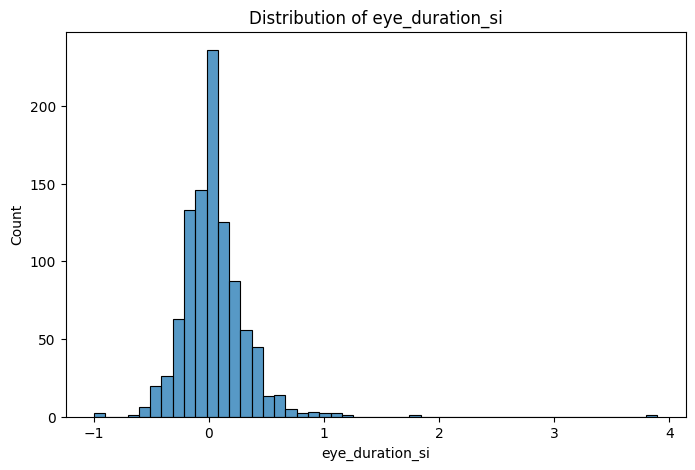

In [5]:
# Basic info
print(df_merged3.info())
print(df_merged3.describe())

# Check distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df_merged3)
plt.title('Distribution of Ratings')
plt.show()

# Check distribution by test phase
plt.figure(figsize=(12, 6))
sns.countplot(x='test_phase', hue='label', data=df_merged3)
plt.title('Rating Distribution by Test Phase')
plt.xticks(rotation=45)
plt.show()

# Check distribution by gender
plt.figure(figsize=(8, 5))
sns.countplot(x='sex', hue='label', data=df_merged3)
plt.title('Rating Distribution by Gender')
plt.show()

# Physiological signals distribution (sample a few)
signal_cols = [col for col in df_merged.columns if col not in ['test_phase', 'subject', 'sex', 'age', 'label']]
for signal in np.random.choice(signal_cols, 5):
    plt.figure(figsize=(8, 5))
    sns.histplot(df_merged[signal], bins=50)
    plt.title(f'Distribution of {signal}')
    plt.show()

In [6]:
X = df_merged3[signal_cols]  # Physiological signals
#y = df_merged['label']     # Target variable
groups = df_merged3['subject']  # For group-wise splitting

# Standardization - fit on training, transform both
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Group by subject and scale within each group
X_scaled = X.groupby(df_merged3['subject']).apply(
    lambda x: pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns))
X_scaled = X_scaled.reset_index(drop=True)

ColumnNames = X_scaled.columns
#X_scaled = pd.DataFrame(X_scaled, columns=ColumnNames)
# Split data into train and test sets ensuring no participant is in both
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# train_idx, test_idx = next(gss.split(X, y, groups=groups))

# X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
# y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Verify mean and std
# print(f"Train mean: {np.mean(X_train_scaled):.2f}, std: {np.std(X_train_scaled):.2f}")
# print(f"Test mean: {np.mean(X_test_scaled):.2f}, std: {np.std(X_test_scaled):.2f}")
X_scaled.head(20)

,mean_bpm,std_bpm,median_bpm,mean_ecg_plf,std_ecg_plf,mean_ecg_phf,std_ecg_phf,mean_ecg_plf_phf,std_ecg_plf_phf,mean_eda_scl,...,eye_velocity_single_si,eye_velocity_over_duration_phase_si,eye_relative_diameter_left,eye_relative_diameter_right,eye_phf_x,eye_plf_x,eye_plf_phf_ratio_x,eye_phf_y,eye_plf_y,eye_plf_phf_ratio_y
0,-0.958976,2.114811,-0.770478,2.086357,2.265400,-0.823514,2.111356,2.047984,2.556427,-0.124533,...,1.034926,-0.905036,0.267824,-0.367206,-0.366428,0.378852,1.409880,-1.335056,-1.127360,2.066471
1,-0.653488,0.081369,-0.519274,0.636735,-1.234038,1.267216,-0.481572,-0.450917,-0.851008,2.615347,...,1.018666,1.462669,1.668814,-1.742090,0.628835,0.687929,-0.324455,1.467921,1.290047,-1.309323
2,-0.402163,-1.786695,-0.519167,-1.437049,0.893797,0.486600,-0.994909,-1.188813,-0.444194,-0.264727,...,-0.867862,-0.481254,1.168629,-1.279647,-1.603914,-1.600746,1.033606,1.554397,1.256604,-1.525761
3,1.492039,1.288886,1.199388,-0.731581,-0.044956,-0.944882,-0.721116,-0.030676,-0.511332,-1.350365,...,1.443985,1.566280,-0.531556,0.663781,1.692844,0.482241,-2.495797,-0.333094,-0.557284,-0.493698
4,-0.337608,-0.227088,-0.155780,0.647086,-0.604108,-0.206628,-1.101675,0.321074,-0.959680,0.632333,...,0.429300,0.645530,0.091562,0.055047,0.891620,0.995378,-0.381509,-0.518474,-0.516237,0.236930
5,-0.284053,-0.130572,-0.265375,-1.315288,0.431870,1.851589,-0.051026,-1.613302,-0.139808,-0.788145,...,0.808477,0.966598,-1.375688,1.151369,1.221029,1.782135,0.122817,-0.705963,-0.583275,0.770101
6,2.335571,-0.279865,2.509740,-0.558410,0.452457,-0.327275,1.265245,-0.074695,0.953931,-0.281122,...,-1.061052,-0.846800,-1.519870,1.569042,-0.988633,-1.088308,0.345145,0.047817,-0.037793,-0.449037
7,-0.169059,-0.130940,-0.045634,0.366034,-0.915959,-1.463932,0.246763,1.071265,-0.110233,0.091994,...,-0.492809,-0.400002,-0.836652,0.753258,-0.371237,-0.160816,0.486899,0.407562,0.869552,0.418483
8,-0.691064,-0.653367,-0.770265,0.154435,-0.326664,0.733173,-0.801778,-0.444596,-0.632384,-0.292880,...,-0.865352,-0.766740,0.620122,-0.590671,-0.448638,-0.492411,0.093375,0.809480,1.050907,-0.291181
9,-0.331200,-0.276537,-0.663155,0.151681,-0.917799,-0.572348,0.528712,0.362676,0.138281,-0.237902,...,-1.448279,-1.241245,0.446815,-0.212882,-0.655478,-0.984254,-0.289960,-1.394590,-1.645161,0.577015


## Dimensionality Reduction and Feature Selection

In [ ]:
# PCA for visualization and potential dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Visualization of Reduced Data

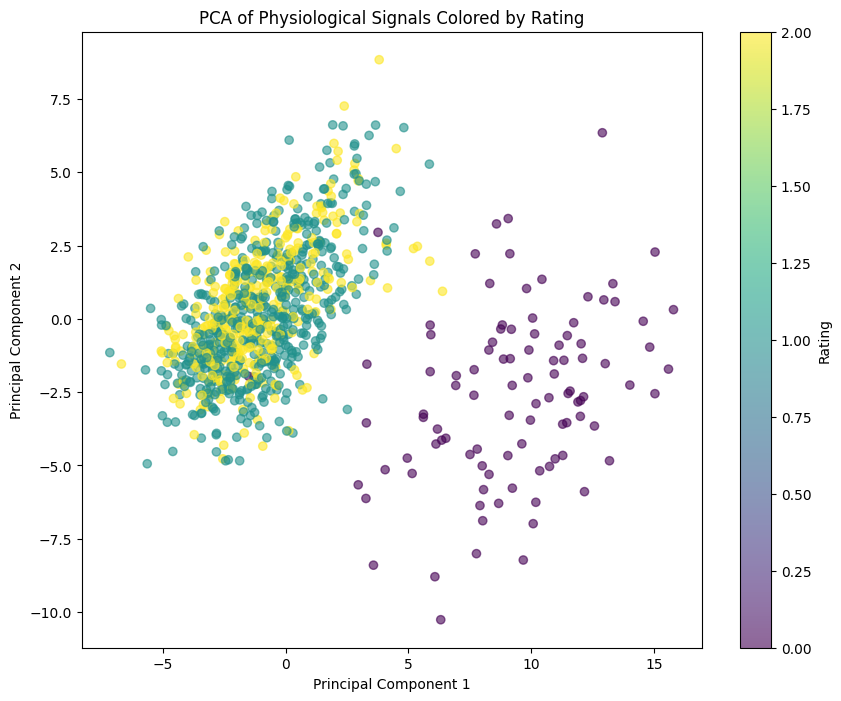

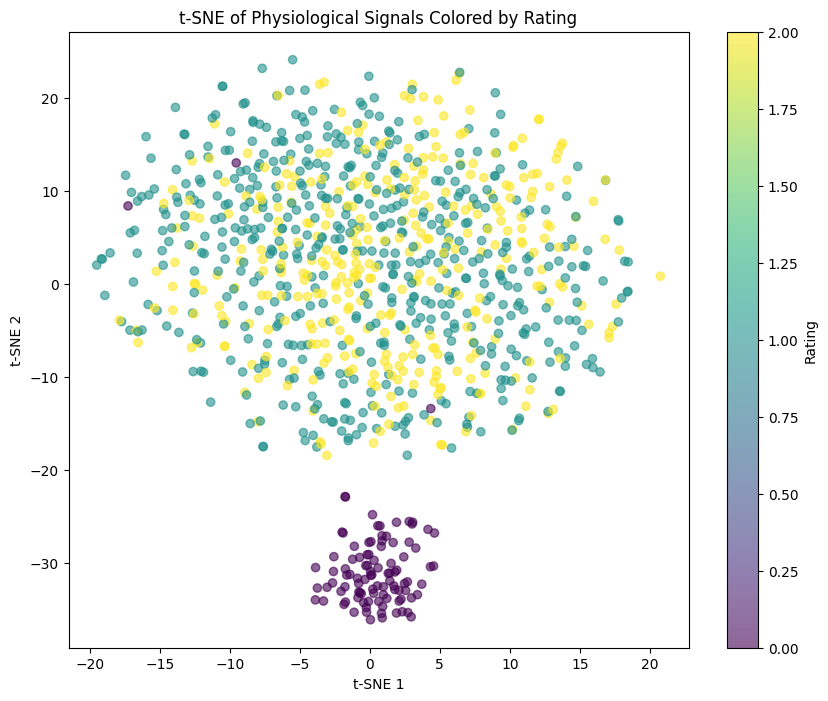

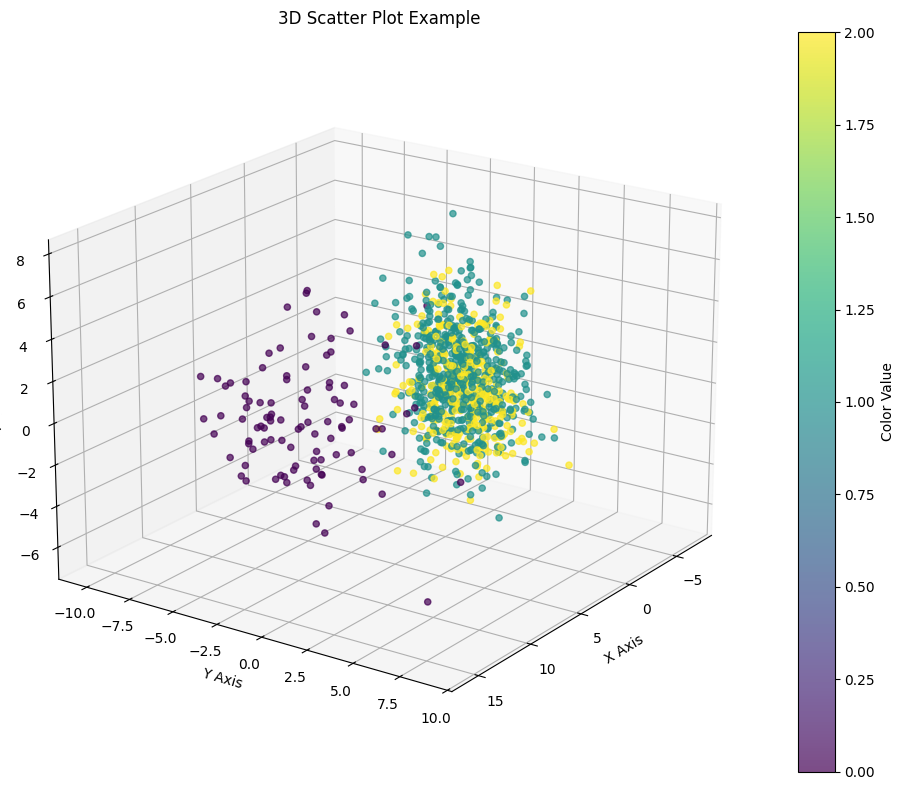

In [8]:
# Plot first two PCA components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Rating')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Physiological Signals Colored by Rating')
plt.show()

# t-SNE for better visualization of clusters (might be slow for large datasets)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
# X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Rating')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Physiological Signals Colored by Rating')
plt.show()

from mpl_toolkits.mplot3d import Axes3D

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Generate sample data
np.random.seed(42)

# Create scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.7)

# Add color bar
fig.colorbar(scatter, ax=ax, label='Color Value')

# Add labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Scatter Plot Example')

# Adjust viewing angle (elevation and azimuth)
ax.view_init(elev=20, azim=35)

plt.tight_layout()
plt.show()

## Train-Test Split

Define split stratify function

In [9]:
def df_split_stratified_grouped(df:pd.DataFrame, test_size=0.2) -> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame,pd.DataFrame]:

    columns = df.columns
    feature = columns.drop(['label'])

    X = df[feature].values  # Features
    y = df['label'].values      # Target variable
    #groups = df['participant'].values  # Participant group
    groups = df['subject'].values  # Participant group

    best_sse=1000
    best_seed=0

    for seed in range(0,100):
        group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

        # Split the data into train and test sets based on the groups
        for train_index, test_index in group_splitter.split(X, y, groups):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Identify groups in the training and test sets
            train_groups = set(groups[train_index])
            test_groups = set(groups[test_index])

        X_train_df = pd.DataFrame(X_train, columns=feature)
        X_test_df = pd.DataFrame(X_test, columns=feature)
        y_train_df = pd.DataFrame(y_train, columns=['label'])
        y_test_df = pd.DataFrame(y_test, columns=['label'])

        class_0_train = y_train_df[y_train_df['label'] == 0]
        class_1_train = y_train_df[y_train_df['label'] == 1]
        class_2_train = y_train_df[y_train_df['label'] == 2]
        #class_3_train = y_train_df[y_train_df['label'] == 3]

        class_0_test = y_test_df[y_test_df['label'] == 0]
        class_1_test = y_test_df[y_test_df['label'] == 1]
        class_2_test = y_test_df[y_test_df['label'] == 2]
        #class_3_test = y_test_df[y_test_df['label'] == 3]

        class_0_test_ratio = len(class_0_test) / (len(class_0_train)+len(class_0_test))
        class_1_test_ratio = len(class_1_test) / (len(class_1_train)+len(class_1_test))
        class_2_test_ratio = len(class_2_test) / (len(class_2_train)+len(class_2_test))
        #class_3_test_ratio = len(class_3_test) / (len(class_3_train)+len(class_3_test))

        sse=abs(class_0_test_ratio-0.2)**2+abs(class_1_test_ratio-0.2)**2+abs(class_2_test_ratio-0.2)**2
        #+abs(class_3_test_ratio-0.2)**2
        if sse<best_sse:
            best_sse=sse
            best_seed=seed
            best_X_train_df=X_train_df
            best_X_test_df=X_test_df
            best_y_train_df=y_train_df
            best_y_test_df=y_test_df

            # name of participants in train and test set
            best_train_groups = train_groups
            best_test_groups = test_groups


    class_0_train = best_y_train_df[best_y_train_df['label'] == 0]
    class_1_train = best_y_train_df[best_y_train_df['label'] == 1]
    class_2_train = best_y_train_df[best_y_train_df['label'] == 2]
    #class_3_train = best_y_train_df[best_y_train_df['label'] == 3]

    class_0_test = best_y_test_df[best_y_test_df['label'] == 0]
    class_1_test = best_y_test_df[best_y_test_df['label'] == 1]
    class_2_test = best_y_test_df[best_y_test_df['label'] == 2]
    #class_3_test = best_y_test_df[best_y_test_df['label'] == 3]

    class_0_test_ratio = len(class_0_test) / (len(class_0_train)+len(class_0_test))
    class_1_test_ratio = len(class_1_test) / (len(class_1_train)+len(class_1_test))
    class_2_test_ratio = len(class_2_test) / (len(class_2_train)+len(class_2_test))
    #class_3_test_ratio = len(class_3_test) / (len(class_3_train)+len(class_3_test))

    print(f"Best Seed: {best_seed} - Best SSE: {best_sse}")
    print(f"Class 0 Test Ratio: {class_0_test_ratio},n_class_0_test: {len(class_0_test)}, n_class_0_train: {len(class_0_train)}")
    print(f"Class 1 Test Ratio: {class_1_test_ratio},n_class_1_test: {len(class_1_test)}, n_class_1_train: {len(class_1_train)}")
    print(f"Class 2 Test Ratio: {class_2_test_ratio},n_class_2_test: {len(class_2_test)}, n_class_2_train: {len(class_2_train)}")
    #print(f"Class 3 Test Ratio: {class_3_test_ratio},n_class_3_test: {len(class_3_test)}, n_class_3_train: {len(class_3_train)}")

    best_train_groups_sorted = sorted(int(num) for num in best_train_groups)
    best_test_groups_sorted = sorted(int(num) for num in best_test_groups)
    print("Training Groups:", best_train_groups_sorted)
    print("Test Groups:", best_test_groups_sorted)

    for n_samples_for_participant in best_X_train_df["subject"].value_counts():
    #for n_samples_for_participant in best_X_train_df["participant"].value_counts():
        if n_samples_for_participant!=10:
            print("Errore")
            #sys.exit(-1)
    for n_samples_for_participant in best_X_test_df["subject"].value_counts():
    #for n_samples_for_participant in best_X_test_df["participant"].value_counts():
        if n_samples_for_participant!=10:
            print("Errore")
            #sys.exit(-1)
    return best_X_train_df, best_X_test_df, best_y_train_df, best_y_test_df

Apply the function and get train-test split

In [10]:
# ✅ Scaled df_merged
df_merged3_scaled = df_merged3.copy()
df_merged3_scaled[signal_cols] = X_scaled

# ✅ Stratified Group Split
X_train, X_test, y_train_df, y_test_df = df_split_stratified_grouped(df_merged3_scaled, test_size=0.2)
group_train_df = X_train['subject']
group_test_df = X_test['subject']

# ✅ Drop non-numeric columns
X_train_df = X_train.drop(columns=['test_phase', 'subject', 'sex', 'age'])
X_test_df = X_test.drop(columns=['test_phase', 'subject', 'sex', 'age'])

Best Seed: 53 - Best SSE: 1.204986509374551e-05
Class 0 Test Ratio: 0.20202020202020202,n_class_0_test: 20, n_class_0_train: 79
Class 1 Test Ratio: 0.20257826887661143,n_class_1_test: 110, n_class_1_train: 433
Class 2 Test Ratio: 0.20114942528735633,n_class_2_test: 70, n_class_2_train: 278
Training Groups: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 31, 32, 33, 35, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 61, 62, 63, 64, 65, 66, 68, 69, 70, 72, 73, 75, 78, 79, 80, 81, 84, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103]
Test Groups: [4, 20, 30, 34, 36, 42, 45, 52, 58, 59, 60, 67, 71, 74, 76, 82, 83, 85, 86, 101]


Correct the value types to use in neural networks

In [11]:
# Your input data
X_train_np = X_train_df.values
y_train_np = y_train_df.values.ravel()
# y_train_np = y_train_df.values
group_train_np = group_train_df.values.ravel()
X_test_np = X_test_df.values
y_test_np = y_test_df.values.ravel()
#y_test_np = y_test_df.values
group_test_np = group_test_df.values.ravel()

# Ensure correct dtype for X_train_np and y_train_np
X_train_np = np.array(X_train_np, dtype=np.float32)
y_train_np = np.array(y_train_np, dtype=np.float32)
X_test_np = np.array(X_test_np, dtype=np.float32)
y_test_np = np.array(y_test_np, dtype=np.float32)

In [12]:
# Your input data
X_train_np = X_train_df.values
y_train_np = y_train_df.values.ravel()
# y_train_np = y_train_df.values
group_train_np = group_train_df.values.ravel()
X_test_np = X_test_df.values
y_test_np = y_test_df.values.ravel()
#y_test_np = y_test_df.values
group_test_np = group_test_df.values.ravel()

# Ensure correct dtype for X_train_np and y_train_np
X_train_np = np.array(X_train_np, dtype=np.float32)
y_train_np = np.array(y_train_np, dtype=np.float32)
X_test_np = np.array(X_test_np, dtype=np.float32)
y_test_np = np.array(y_test_np, dtype=np.float32)


from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weights = dict(enumerate(class_weights_array))



# Optional: Normalize physiological data (very important for many models)
scaler = StandardScaler()
X_train_np_sca = scaler.fit_transform(X_train_np)

X_test_np_sca = scaler.transform(X_test_np)

#from sklearn.preprocessing import MinMaxScaler

# Fit on training data
#mm_scaler = MinMaxScaler()
#X_train_np_sca = mm_scaler.fit_transform(X_train_np)
#X_test_np_sca = mm_scaler.transform(X_test_np)



from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Try selecting top 30 features
selector = SelectKBest(score_func=mutual_info_classif, k=60)
X_train_selected = selector.fit_transform(X_train_np_sca, y_train_np)
X_test_selected = selector.transform(X_test_np_sca)

from sklearn.decomposition import PCA

# Reduce to 30 principal components
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_np)
X_test_pca = pca.transform(X_test_np)




## Regularized model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from keras_tuner import RandomSearch
from tensorflow import keras
from keras import layers, regularizers
import numpy as np
import tensorflow.keras.backend as K

#import shutil
#shutil.rmtree("output/classification_model", ignore_errors=True)

def build_model(hp, input_dim):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(layers.Dense(
            hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
            activation=hp.Choice("activation", ["relu", "tanh"]),
            kernel_regularizer=regularizers.l2(hp.Float('l2', 1e-5, 1e-3, sampling='LOG'))
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)))

    model.add(layers.Dense(3, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def run_kfold_tuned(X, y, X_test, y_test, n_splits=5, max_trials=10, epochs=50, patience=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_preds, all_true = [], []

    best_fold_model = None  # Save best model for final test eval
    best_val_accuracy = -1
    histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n=== Fold {fold}/{n_splits} ===")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        def model_builder(hp):
            return build_model(hp, input_dim=X.shape[1])

        tuner = RandomSearch(
            model_builder,
            objective='val_accuracy',
            max_trials=max_trials,
            executions_per_trial=1,
            overwrite=True,
            directory='fold_tuning',
            project_name=f'fold_{fold}'
        )

        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=patience,
            restore_best_weights=True, verbose=0
        )

        tuner.search(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=[early_stop],
            verbose=0
        )

        best_model = tuner.get_best_models(1)[0]
        best_hp = tuner.get_best_hyperparameters(1)[0]

        history = best_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=[early_stop],
            verbose=0
        )

        histories.append(history)

        # Track best performing fold model on validation set
        val_acc = history.history["val_accuracy"][-1]
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_fold_model = best_model

        y_pred = np.argmax(best_model.predict(X_val), axis=1)
        all_preds.extend(y_pred)
        all_true.extend(y_val)

        # print(f"Fold {fold} Classification Report:")
        # print(classification_report(y_val, y_pred))

        K.clear_session()

    # # Combined K-Fold results
    # print("\n=== Final Combined Classification Report ===")
    # print(classification_report(all_true, all_preds))
    # print("Confusion Matrix:")
    # print(confusion_matrix(all_true, all_preds))

    # # Plotting training curves for last fold
    # print("\n=== Training Curves for Last Fold ===")
    # plt.figure(figsize=(12, 5))

    # plt.subplot(1, 2, 1)
    # plt.plot(history.history['loss'], label='Train Loss')
    # plt.plot(history.history['val_loss'], label='Val Loss')
    # plt.title('Loss vs Epochs')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.plot(history.history['accuracy'], label='Train Accuracy')
    # plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    # plt.title('Accuracy vs Epochs')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.grid(True)

    # plt.tight_layout()
    # plt.show()

    # # Final test set evaluation with best model from best fold
    # print("\n=== Final Test Set Evaluation ===")
    # test_loss, test_acc = best_fold_model.evaluate(X_test, y_test, verbose=0)
    # print(f"Test Loss: {test_loss:.4f}")
    # print(f"Test Accuracy: {test_acc:.4f}")

    # y_pred_test = np.argmax(best_fold_model.predict(X_test), axis=1)
    # print("\nTest Set Classification Report:")
    # print(classification_report(y_test, y_pred_test))
    # print("Test Set Confusion Matrix:")
    # print(confusion_matrix(y_test, y_pred_test))

    return best_fold_model, best_hp



In [ ]:
best_model, best_hp = run_kfold_tuned(
    X=X_train_np_sca,
    y=y_train_np,
    X_test=X_test_np_sca,
    y_test=y_test_np,
    max_trials=20,
    epochs=50,
    patience=5
)

In [24]:
retrained_model = build_model(best_hp, input_dim=X_train_np_sca.shape[1])

# === Retrain from scratch ===
history = retrained_model.fit(
    X_train_np_sca,
    y_train_np,
    epochs=120,
    validation_split=0.2,
    verbose=0
)

print(retrained_model.summary())
for hp_name in best_hp.values:
    print(f"{hp_name}: {best_hp.get(hp_name)}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         8,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         7,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,123 (195.80 KB)

 Trainable params: 16,707 (65.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,416 (130.54 KB)

None
num_layers: 2
units_0: 80
activation: tanh
l2: 0.0003657308695459229
dropout_0: 0.1
units_1: 96
dropout_1: 0.4
units_2: 112
dropout_2: 0.4


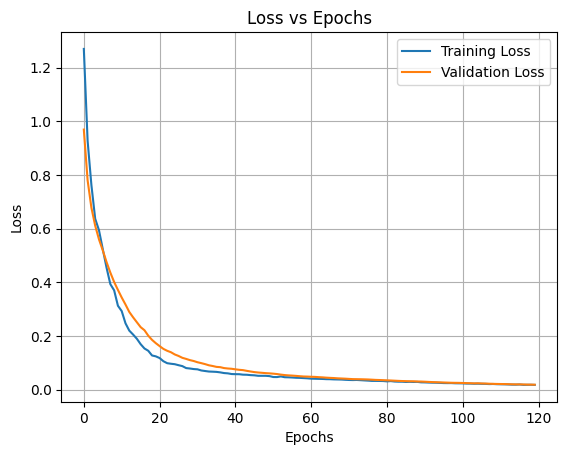

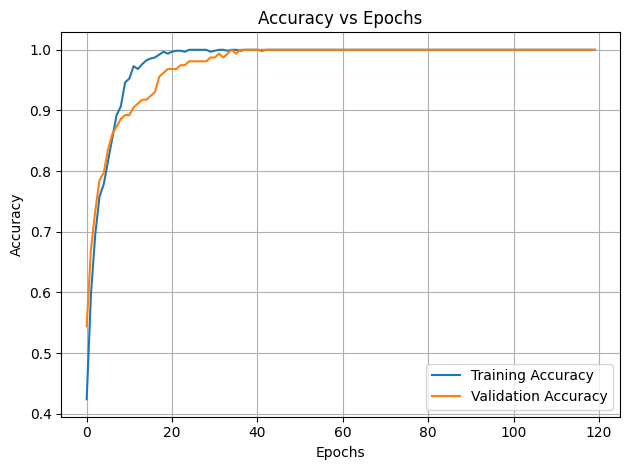

In [18]:
plt.figure()

#plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.figure()
# plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:

# === Evaluate best model on test set ===
test_loss, test_acc = retrained_model.evaluate(X_test_np_sca, y_test_np, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = np.argmax(retrained_model.predict(X_test_np_sca), axis=1)
print("\nTest Classification Report:")
print(classification_report(y_test_np, y_test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test_np, y_test_pred))


Test Loss: 0.0321
Test Accuracy: 0.9950
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Test Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       0.99      1.00      1.00       110
         2.0       1.00      1.00      1.00        70

    accuracy                           0.99       200
   macro avg       1.00      0.98      0.99       200
weighted avg       1.00      0.99      0.99       200

Test Confusion Matrix:
[[ 19   1   0]
 [  0 110   0]
 [  0   0  70]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


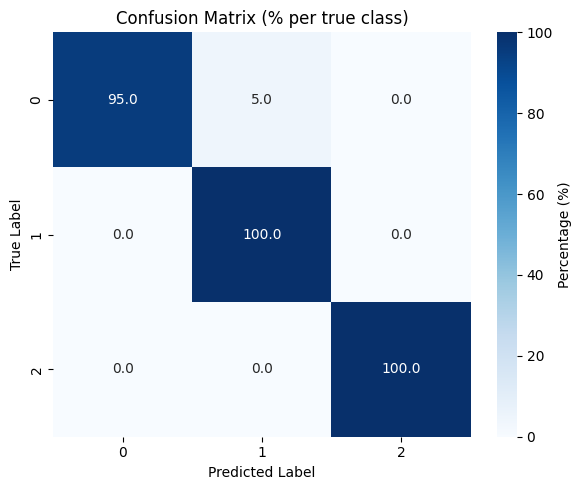

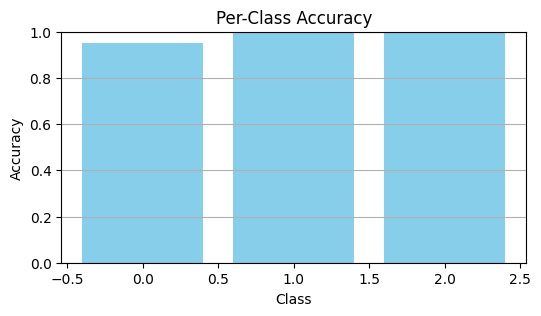

' # === 3. ROC Curves per class ===\nfpr = {}\ntpr = {}\nroc_auc = {}\nfor i in range(3):\n    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nplt.figure(figsize=(8, 6))\nfor i in range(3):\n    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")\nplt.plot([0, 1], [0, 1], linestyle=\'--\', color=\'gray\')\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\nplt.title("ROC Curves")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n\n# === 4. Precision-Recall Curves per class ===\nplt.figure(figsize=(8, 6))\nfor i in range(3):\n    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_test_prob[:, i])\n    ap = average_precision_score(y_test_bin[:, i], y_test_prob[:, i])\n    plt.plot(recall, precision, label=f"Class {i} (AP = {ap:.2f})")\nplt.xlabel("Recall")\nplt.ylabel("Precision")\nplt.title("Precision-Recall Curves")\nplt.legend()\nplt.grid(True)\nplt.tight_layout(

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve

# === Get predictions and probabilities ===
y_test_pred = np.argmax(retrained_model.predict(X_test_np_sca), axis=1)
y_test_prob = retrained_model.predict(X_test_np_sca)
y_test_bin = label_binarize(y_test_np, classes=np.arange(3))  # for 3-class case

# Get confusion matrix
cm = confusion_matrix(y_test_np, y_test_pred)

# Normalize per row (true class) to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]),
            cbar_kws={'label': 'Percentage (%)'})

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (% per true class)")
plt.tight_layout()
plt.show()

# === 2. Per-Class Accuracy (Bar Plot) ===
class_accs = [accuracy_score(y_test_np[y_test_np == i], y_test_pred[y_test_np == i]) for i in range(3)]
plt.figure(figsize=(6, 3))
plt.bar(range(3), class_accs, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.grid(axis='y')
plt.show()